In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od

import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

import keras
from keras.applications import VGG19
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from google.colab import files
import shutil

In [3]:
# {"username":"miguelgallego","key":"6a7a2546d0b0a5683db1abd67fc0380c"}
dataset_link = "https://www.kaggle.com/datasets/harishkumardatalab/food-image-classification-dataset"
od.download(dataset_link)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: miguelgallego
Your Kaggle Key: ··········


100%|██████████| 1.68G/1.68G [01:34<00:00, 19.0MB/s]


In [4]:
# Carga el DataFrame desde el archivo CSV
balanced_data = pd.read_csv('balanced_data.csv')

In [5]:
balanced_data

,filename,class
0,/content/food-image-classification-dataset/Foo...,Hot Dog
1,/content/food-image-classification-dataset/Foo...,Hot Dog
2,/content/food-image-classification-dataset/Foo...,Hot Dog
3,/content/food-image-classification-dataset/Foo...,Hot Dog
4,/content/food-image-classification-dataset/Foo...,Hot Dog
...,...,...
23781,/content/food-image-classification-dataset/Foo...,pakode
23782,/content/food-image-classification-dataset/Foo...,pakode
23783,/content/food-image-classification-dataset/Foo...,pakode
23784,/content/food-image-classification-dataset/Foo...,pakode


In [6]:
# Dividir los datos en entrenamiento (70%) y temporales (30%)
train_data, temp_data = train_test_split(balanced_data, test_size=0.3, random_state=42)

# Dividir los datos temporales en validación (50%) y prueba (50%)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [7]:
# Crea y define el ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0/255, # Normalizar los valores de píxeles al rango [0, 1]
    preprocessing_function=keras.applications.vgg19.preprocess_input # imagenes rgb a bgr
)

batch_size = 32

# Crear generadores de datos para entrenamiento, validación y prueba
train_generator = datagen.flow_from_dataframe(
    dataframe = train_data,
    target_size=(224, 224),  # Ajusta el tamaño según tu modelo
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = datagen.flow_from_dataframe(
    dataframe = validation_data,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # No es necesario mezclar los datos de validación
)

test_generator = datagen.flow_from_dataframe(
    dataframe = test_data,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # No es necesario mezclar los datos de prueba
)

# images, img_labels = next(train_generator)
# print("Forma del lote de imágenes:", images.shape)

Found 16650 validated image filenames belonging to 30 classes.
Found 3568 validated image filenames belonging to 30 classes.
Found 3568 validated image filenames belonging to 30 classes.


Forma del lote de imágenes: (32, 224, 224, 3)


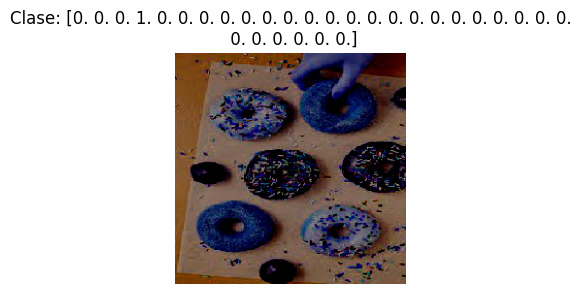

In [8]:
# Tomar un lote de imágenes del generador
images, img_labels = next(train_generator)

# Verificar las formas de las imágenes en el lote
print("Forma del lote de imágenes:", images.shape)  # Debería ser (batch_size, height, width, channels)

# Seleccionar una imagen del lote (por ejemplo, la primera imagen)
image = images[31]  # Cambia el índice si se desea visualizar otra imagen

# Mostrar la imagen utilizando Matplotlib
plt.figure(figsize=(3, 3))
plt.imshow(image.squeeze())  # Asegúrate de usar 'gray' para imágenes en escala de grises
plt.axis('off')  # Deshabilita los ejes
plt.title(f'Clase: {img_labels[0]}')  # Muestra la etiqueta de clase (cambia si no usas one-hot encoding)
plt.show()

In [9]:
# Cargar y visualizar modelo preentrenado
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()

80134624/80134624 [==============================] - 5s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [10]:
# Número de clases que serviran a la última capa de salida
classes_number = balanced_data['class'].value_counts().count()

# Congelar capas
for layer in base_model.layers:
    layer.trainable = False

# Crear un modelo secuencial y agregar las capas personalizadas
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(classes_number = balanced_data['class'].value_counts().count()
, activation='softmax'))  # 30 clases en tu caso

In [11]:
# Compila el modelo
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Define una función de retorno de llamada para guardar el modelo en cada época
checkpoint = ModelCheckpoint(
    'best_model_tf',  # Nombre del archivo donde se guardarán los pesos del modelo
    monitor='val_accuracy',  # Métrica para monitorear (puede ser 'val_loss', 'val_accuracy', etc.)
    save_best_only=True,  # Solo guarda el modelo si la métrica mejora
    mode='max',  # 'max' para maximizar la métrica, 'min' para minimizar la métrica
    verbose=1  # Muestra un mensaje cuando se guarda el modelo
)

# Define una función de retorno de llamada para detener el entrenamiento si no hay mejoras
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Métrica para monitorear
    patience=5,  # Número de épocas sin mejora antes de detener el entrenamiento
    verbose=1,  # Muestra un mensaje cuando se detiene el entrenamiento
    mode='max'  # 'max' para maximizar la métrica, 'min' para minimizar la métrica
)

# Entrenar el modelo utilizando los generadores de datos
epochs = 50 # Número de épocas
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Número total de lotes por época
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,  # Número total de lotes de validación por época
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
427/520 [=======================>......] - ETA: 30s - loss: 2.7862 - accuracy: 0.2444

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 2.6660 - accuracy: 0.2780
Epoch 1: val_accuracy improved from -inf to 0.61909, saving model to best_model_tf
520/520 [==============================] - 220s 397ms/step - loss: 2.6660 - accuracy: 0.2780 - val_loss: 1.6197 - val_accuracy: 0.6191
Epoch 2/50
117/520 [=====>........................] - ETA: 2:02 - loss: 1.8752 - accuracy: 0.4847

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 1.6756 - accuracy: 0.5371
Epoch 2: val_accuracy improved from 0.61909 to 0.70073, saving model to best_model_tf
520/520 [==============================] - 213s 409ms/step - loss: 1.6756 - accuracy: 0.5371 - val_loss: 1.1279 - val_accuracy: 0.7007
Epoch 3/50
432/520 [=======================>......] - ETA: 28s - loss: 1.3083 - accuracy: 0.6285

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 1.2912 - accuracy: 0.6321
Epoch 3: val_accuracy improved from 0.70073 to 0.72100, saving model to best_model_tf
520/520 [==============================] - 206s 396ms/step - loss: 1.2912 - accuracy: 0.6321 - val_loss: 0.9938 - val_accuracy: 0.7210
Epoch 4/50
269/520 [==============>...............] - ETA: 1:22 - loss: 1.1017 - accuracy: 0.6787

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 1.0865 - accuracy: 0.6834
Epoch 4: val_accuracy improved from 0.72100 to 0.74268, saving model to best_model_tf
520/520 [==============================] - 205s 395ms/step - loss: 1.0865 - accuracy: 0.6834 - val_loss: 0.8870 - val_accuracy: 0.7427
Epoch 5/50
293/520 [===============>..............] - ETA: 1:15 - loss: 0.9395 - accuracy: 0.7278

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 0.9421 - accuracy: 0.7240
Epoch 5: val_accuracy improved from 0.74268 to 0.74465, saving model to best_model_tf
520/520 [==============================] - 208s 400ms/step - loss: 0.9421 - accuracy: 0.7240 - val_loss: 0.8496 - val_accuracy: 0.7447
Epoch 6/50
138/520 [======>.......................] - ETA: 2:02 - loss: 0.8410 - accuracy: 0.7516

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 0.8233 - accuracy: 0.7585
Epoch 6: val_accuracy improved from 0.74465 to 0.75957, saving model to best_model_tf
520/520 [==============================] - 207s 397ms/step - loss: 0.8233 - accuracy: 0.7585 - val_loss: 0.8257 - val_accuracy: 0.7596
Epoch 7/50
168/520 [========>.....................] - ETA: 1:56 - loss: 0.7268 - accuracy: 0.7824

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 0.7300 - accuracy: 0.7827
Epoch 7: val_accuracy did not improve from 0.75957
520/520 [==============================] - 203s 391ms/step - loss: 0.7300 - accuracy: 0.7827 - val_loss: 0.8079 - val_accuracy: 0.7596
Epoch 8/50
520/520 [==============================] - ETA: 0s - loss: 0.6603 - accuracy: 0.8003
Epoch 8: val_accuracy improved from 0.75957 to 0.76689, saving model to best_model_tf
520/520 [==============================] - 206s 396ms/step - loss: 0.6603 - accuracy: 0.8003 - val_loss: 0.7960 - val_accuracy: 0.7669
Epoch 9/50
488/520 [===========================>..] - ETA: 10s - loss: 0.5831 - accuracy: 0.8252

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 0.5825 - accuracy: 0.8256
Epoch 9: val_accuracy improved from 0.76689 to 0.76802, saving model to best_model_tf
520/520 [==============================] - 208s 400ms/step - loss: 0.5825 - accuracy: 0.8256 - val_loss: 0.7720 - val_accuracy: 0.7680
Epoch 10/50
430/520 [=======================>......] - ETA: 29s - loss: 0.5147 - accuracy: 0.8432

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 0.5205 - accuracy: 0.8423
Epoch 10: val_accuracy did not improve from 0.76802
520/520 [==============================] - 212s 407ms/step - loss: 0.5205 - accuracy: 0.8423 - val_loss: 0.7861 - val_accuracy: 0.7660
Epoch 11/50
520/520 [==============================] - ETA: 0s - loss: 0.4688 - accuracy: 0.8572
Epoch 11: val_accuracy did not improve from 0.76802
520/520 [==============================] - 204s 392ms/step - loss: 0.4688 - accuracy: 0.8572 - val_loss: 0.7971 - val_accuracy: 0.7658
Epoch 12/50
520/520 [==============================] - ETA: 0s - loss: 0.4209 - accuracy: 0.8750
Epoch 12: val_accuracy improved from 0.76802 to 0.77196, saving model to best_model_tf
520/520 [==============================] - 208s 400ms/step - loss: 0.4209 - accuracy: 0.8750 - val_loss: 0.7754 - val_accuracy: 0.7720
Epoch 13/50
393/520 [=====================>........] - ETA: 42s - loss: 0.3816 - accuracy: 0.8843

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 0.3884 - accuracy: 0.8830
Epoch 13: val_accuracy did not improve from 0.77196
520/520 [==============================] - 209s 401ms/step - loss: 0.3884 - accuracy: 0.8830 - val_loss: 0.7959 - val_accuracy: 0.7635
Epoch 14/50
520/520 [==============================] - ETA: 0s - loss: 0.3565 - accuracy: 0.8916
Epoch 14: val_accuracy improved from 0.77196 to 0.77506, saving model to best_model_tf
520/520 [==============================] - 205s 395ms/step - loss: 0.3565 - accuracy: 0.8916 - val_loss: 0.7818 - val_accuracy: 0.7751
Epoch 15/50
171/520 [========>.....................] - ETA: 2:03 - loss: 0.3094 - accuracy: 0.9075

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 0.3126 - accuracy: 0.9049
Epoch 15: val_accuracy improved from 0.77506 to 0.77618, saving model to best_model_tf
520/520 [==============================] - 208s 401ms/step - loss: 0.3126 - accuracy: 0.9049 - val_loss: 0.7944 - val_accuracy: 0.7762
Epoch 16/50
463/520 [=========================>....] - ETA: 18s - loss: 0.2874 - accuracy: 0.9138

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 0.2872 - accuracy: 0.9146
Epoch 16: val_accuracy improved from 0.77618 to 0.77984, saving model to best_model_tf
520/520 [==============================] - 208s 400ms/step - loss: 0.2872 - accuracy: 0.9146 - val_loss: 0.7909 - val_accuracy: 0.7798
Epoch 17/50
154/520 [=======>......................] - ETA: 2:02 - loss: 0.2629 - accuracy: 0.9170

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 0.2588 - accuracy: 0.9207
Epoch 17: val_accuracy did not improve from 0.77984
520/520 [==============================] - 209s 403ms/step - loss: 0.2588 - accuracy: 0.9207 - val_loss: 0.8341 - val_accuracy: 0.7697
Epoch 18/50
520/520 [==============================] - ETA: 0s - loss: 0.2410 - accuracy: 0.9286
Epoch 18: val_accuracy did not improve from 0.77984
520/520 [==============================] - 203s 390ms/step - loss: 0.2410 - accuracy: 0.9286 - val_loss: 0.8011 - val_accuracy: 0.7753
Epoch 19/50
520/520 [==============================] - ETA: 0s - loss: 0.2192 - accuracy: 0.9333
Epoch 19: val_accuracy did not improve from 0.77984
520/520 [==============================] - 202s 389ms/step - loss: 0.2192 - accuracy: 0.9333 - val_loss: 0.8249 - val_accuracy: 0.7762
Epoch 20/50
520/520 [==============================] - ETA: 0s - loss: 0.2112 - accuracy: 0.9344
Epoch 20: val_accuracy did not improve from 0.77984
520/520 [==

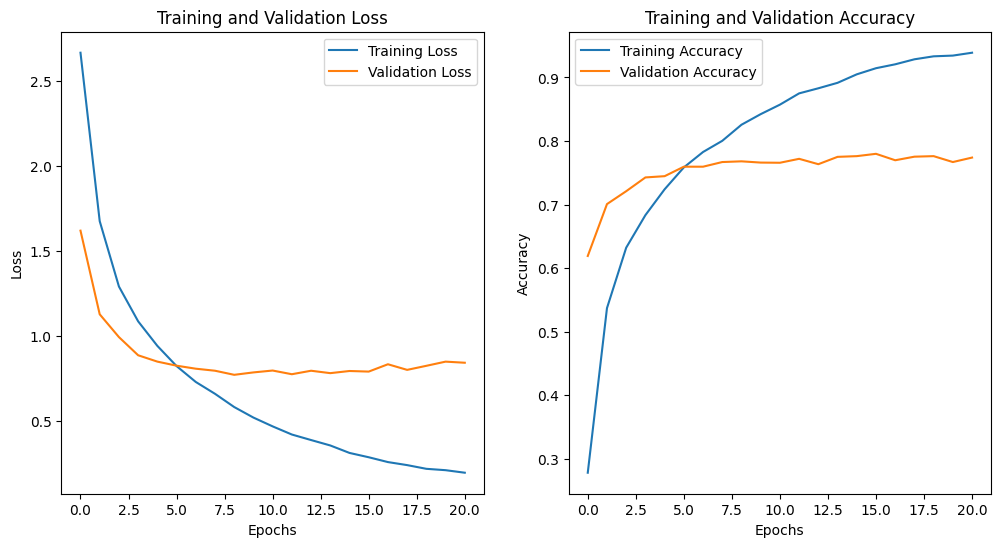

In [12]:
# Get the training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.show()

In [14]:
# Comprilir archivo para GCP
shutil.make_archive("best_model_tf", "zip", ".", "best_model_tf")

# Descarga el modelo entrenado
files.download('best_model_tf.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
# Cargar el modelo
model = load_model('/content/best_model_tf')

In [18]:
# Obtiene perdida y precisión en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Pérdida en el conjunto de prueba: {test_loss}")
print(f"Precisión en el conjunto de prueba: {test_accuracy}")

112/112 [==============================] - 40s 353ms/step - loss: 0.7799 - accuracy: 0.7727
Pérdida en el conjunto de prueba: 0.7798604965209961
Precisión en el conjunto de prueba: 0.7727017998695374


112/112 [==============================] - 35s 310ms/step
Matriz de Confusión:
[[ 77   6   0   0   1   0   7   4   3   0   4   0   1   0   2   0   1   2
    0   0   0   1   2   0   0   3   0   0   0   3]
 [  2  72   0   3   2   2   3   5   0   0   0   0   0   1   4   0   2   6
    0   0   0   1   3   0   1   0   2   1   1   0]
 [  1   2  87   0   2   2   2   2   7   1   1   1   0   3   0   2   1   0
    6   1   0   0   0   0   3   1   1   0   2   2]
 [  1   2   1  94   1   1   8   4   1   0   1   0   0   1   1   0   0   0
    2   0   1   4   0   0   0   1   2   0   1   1]
 [  2   0   1   2  71   4  12   7   3   2   0   0   0   1   1   0   0   0
    1   0   0   1   0   0   1   0   0   0   0   4]
 [  1   2   2   5   3  92   3   7   4   1   0   0   0   2   1   0   0   0
    3   0   0   4   0   1   0   3   0   0   1   2]
 [  3   5   3   1   6   2  65   8   1   0   0   0   0   1   2   0   0   1
    3   0   0   4   0   0   0   6   0   0   1   1]
 [  1   2   1   2   0   4  12  87   1   0   0 

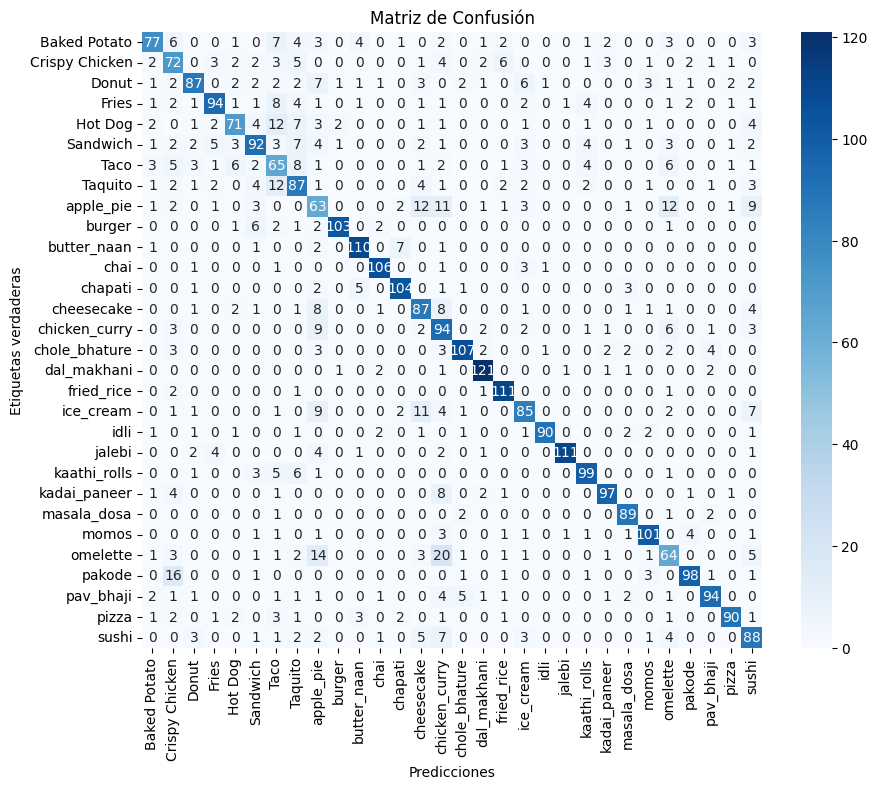

In [19]:
# Predicciones del modelo en el conjunto de datos de prueba
predictions = model.predict(test_generator)
# Convierte las predicciones en etiquetas de clase (por ejemplo, utilizando np.argmax)
predicted_classes = np.argmax(predictions, axis=1)

# Calcula la matriz de confusión
true_classes = test_generator.classes
confusion = confusion_matrix(true_classes, predicted_classes)
print("Matriz de Confusión:")
print(confusion)

# Visualizar la matriz de confusión como un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas verdaderas')
plt.title('Matriz de Confusión')
plt.show()

In [20]:
# Generar un informe de clasificación
class_labels = list(test_generator.class_indices.keys())
class_report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Informe de Clasificación:\n", class_report)

Informe de Clasificación:
                 precision    recall  f1-score   support

  Baked Potato       0.80      0.66      0.72       117
Crispy Chicken       0.56      0.65      0.60       111
         Donut       0.81      0.67      0.73       130
         Fries       0.83      0.73      0.78       128
       Hot Dog       0.77      0.63      0.69       113
      Sandwich       0.74      0.67      0.70       137
          Taco       0.50      0.58      0.53       113
       Taquito       0.62      0.69      0.65       126
     apple_pie       0.45      0.51      0.48       123
        burger       0.95      0.87      0.91       118
   butter_naan       0.88      0.90      0.89       122
          chai       0.91      0.94      0.93       113
       chapati       0.88      0.89      0.89       117
    cheesecake       0.65      0.74      0.69       117
 chicken_curry       0.52      0.76      0.62       124
 chole_bhature       0.88      0.83      0.86       129
   dal_makhani      